In [27]:
import numpy as np
import matplotlib.pyplot as plt
from queue import PriorityQueue # 优先队列
from collections import defaultdict

Example 1

$\rho = \frac{\lambda}{n \mu} = 1.6$，$\mu = 1$，$\theta = 0.5$

不妨取定 $n = 100$，则 $\lambda = 160$

到达顾客服从 $\lambda = 160$ 的 Poisson 过程，顾客耐心 $\text{Exp}(0.5)$，单个服务台的服务时间 $\text{Exp}(1)$

In [28]:
lambda_ = 1600.0
mu = 1.0
theta = 0.5
n = 1000
MAX_TIME = 50.0

先模拟一段足够长的时间中的排队

In [29]:
t = 0.0
arrival_time = 0.0
event_queue = PriorityQueue() # 优先队列，用于取出下一个事件，储存四元组（时刻，顾客编号，事件名，队列号）
queues = tuple([[] for _ in range(n)]) # 排队队列（列表模拟）
arrival_time += np.random.exponential(1 / lambda_) # 下一次到达
customer_cnt = 0
is_in_queue = defaultdict(bool) # 对不存在的键，默认值为 False 的 Hash 表

def get_shortest_queue():
    """
    得到长度最小队伍的编号
    当有多个长度最小的队伍时，返回最小编号
    """
    idx = np.argmin([len(queue) for queue in queues])
    return idx

record_span = 0.2
event_queue.put((record_span, -1, 'record', -1))
records = []
abandon_cnt = 0
while t <= MAX_TIME:
    # 若队头的事件比下一个到达时间早，取出 t
    while not event_queue.empty() and event_queue.queue[0][0] <= arrival_time:
        t, customer_idx, event_name, idx = event_queue.get()
        if event_name == 'record':
            records.append(tuple([len(queue) for queue in queues]))
            event_queue.put((t + record_span, -1, 'record', -1))
            continue

        if event_name == 'finish_service': # 服务完成
            queues[idx].pop(0) # 出队
            # 下一个人开始服务
            if len(queues[idx]):
                event_queue.put((t, queues[idx][0], 'service', idx))
            continue

        if not is_in_queue[customer_idx]: # 若已经离队
            continue

        is_in_queue.pop(customer_idx) # 离开排队（接受服务或放弃）
        if event_name == 'service': # 若是开始服务
            service_time = np.random.exponential(1 / mu)
            event_queue.put((t + service_time, customer_idx, 'finish_service', idx))
            continue

        else: # 放弃
            queues[idx].remove(customer_idx) # 从排队队列中出队
            abandon_cnt += 1
                
    t = arrival_time
    idx = get_shortest_queue()
    queues[idx].append(customer_cnt)
    if queues[idx][0] == customer_cnt: # 如果这个人就在队首
        event_queue.put((t, customer_cnt, 'service', idx))
    patience_time = np.random.exponential(1 / theta)
    event_queue.put((t + patience_time, customer_cnt, 'abandon', idx))
    is_in_queue[customer_cnt] = True
    customer_cnt += 1

    arrival_time += np.random.exponential(1 / lambda_) # 更新新的到达时间


In [30]:
abandon_cnt, customer_cnt

(27873, 80236)

In [31]:
def transform_into_counts(records):
    counts = []
    records = np.array(records)
    for record in records:
        counts.append([
            np.sum(record >= 1),
            np.sum(record >= 2),
            np.sum(record >= 3),
            np.sum(record >= 4)
        ])
    return counts

counts = transform_into_counts(records)
counts = list(zip(*counts))

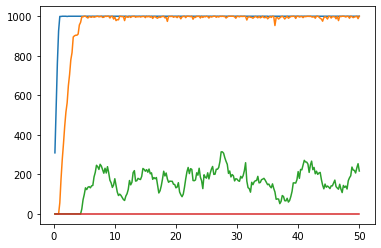

In [32]:
plt.plot(list(np.arange(record_span, MAX_TIME + record_span, record_span)), counts[0])
plt.plot(list(np.arange(record_span, MAX_TIME + record_span, record_span)), counts[1])
plt.plot(list(np.arange(record_span, MAX_TIME + record_span, record_span)), counts[2])
plt.plot(list(np.arange(record_span, MAX_TIME + record_span, record_span)), counts[3])